In [1]:
# Uses data generated in timing_data_generation

# Plot 1:
# Run a dummy Capytaine round to make sure the initial build happens and we're not timing that
# Run Capytaine with evenly-spaced increasing resolution, get times and values.
# Run MEEM with SAME number of terms/region, evenly-spaced increasing resolution, get times and values.
# Designated value at terms = 300 for MEEM.
# All runs should be repeated 20 times and time-averaged to reduce variability.
# Plot the values on the same plot. x = time, y = value.

# Plot 2:
# Stacked plot for a 2-region configuration, how much time each component takes for same terms/region.
# Terms on x, times on y.

# Plot 3:
# Which calculation dominates if you have y regions and x terms/region? Shares legend and colors with plot 2.

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from typing import List, Dict, Any, Optional
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_constants import rho #need for BEM


# Now you can import from the folder structure
# Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
import sys
from pathlib import Path
HERE = Path.cwd().resolve()
utils_path = (HERE / ".." / "sea-lab-utils").resolve()
utils_str = str(utils_path)
if utils_str not in sys.path:
    sys.path.insert(0, utils_str)
from pyplotutilities import colors
colors.get_colors()
print(colors.purple)

figs_path_prefix = str((HERE / ".." / "pubs/JFM/figs").resolve())
store_path_prefix = str((HERE / "data").resolve())

<class 'module'>
['/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash']
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!
#CC79A7


In [3]:
# Variable Definitions & Data Import
h = 50.00 # sea depth [m]
# omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
omega_val = 1
d_in = [14.45, 14.45-7.32-5.08] # drafts [m]
d_out = d_in # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region
heaving = [1, 1]
face_dist = [a_list[0], d_in[0] - d_in[1], a_list[1] - a_list[0], d_in[1]]
face_fracs = [face_dist[i] / sum(face_dist) for i in range(4)]
cpt_divisions = 15
t_density_lst = [[6 + int(i * 27/cpt_divisions), 12 + int(i * 54/cpt_divisions)] for i in range(cpt_divisions)]
face_unit_lst = [10 + int(i * 40/cpt_divisions) for i in range(cpt_divisions)]
nmk_max = 300
nmk_lst = list(range(5, 101, 5))

config = {"h" : h,
          "a" : a_list,
          "d_in" : d_in,
          "d_out" : d_out,
          "heaving": heaving,
          "omega" : omega_val,
          "rho" : rho}

data_file = store_path_prefix + "/timing.pkl"

with open(data_file, 'rb') as file:
    all_data = pickle.load(file)

true_am = all_data["True Added Mass"]
true_dp = all_data["True Damping"]
true_vals = {"Added Mass" : true_am, "Damping" : true_dp}
meem_reorganized_data = all_data["MEEM Data"]
cpt_data = all_data["Capytaine Data"]

named_meem_times = ["Coupling Integrals", "Root Finding", "Matrix Solve",
                    "Bessel Functions", "Hydro Coefficients (Excluding Bessels)"]

In [4]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 12 # x and y label font size
leg_fs = lab_fs * 0.8 # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width

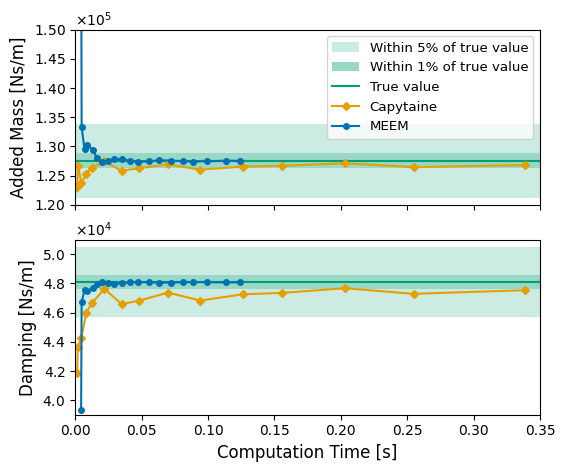

In [5]:
cpt_times = [data["Computation Time"] for data in cpt_data]
meem_times = [data["Total Time"] for data in meem_reorganized_data]

fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex = True)
for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

xlim_max = round(max(cpt_times), 2) + 0.01
true_color = colors.green
ax[0].axhspan(1.01 * true_am, 1.05 * true_am, alpha=0.2, color = true_color,
           linewidth=0, label = "Within 5% of true value")
ax[0].axhspan(0.99 * true_am, 1.01 * true_am, alpha=0.4, color = true_color,
           linewidth=0, label = "Within 1% of true value")
ax[0].axhspan(0.95 * true_am, 0.99 * true_am, alpha=0.2, color = true_color,
           linewidth=0)
ax[0].axhline(true_am, linestyle="-", linewidth=l_width-1.5, color = true_color,
           label = "True value")
ax[0].plot(cpt_times, [data["Added Mass"] for data in cpt_data], color = colors.orange,
        marker='D', markersize=m_size-3, label = "Capytaine")
ax[0].plot(meem_times, [data["Added Mass"] for data in meem_reorganized_data], color=colors.blue,
        marker='o', markersize=m_size-3, label = "MEEM")

ax[0].set_ylim([1.2e5, 1.5e5])
ax[0].set_xlim([0, xlim_max])
ax[0].legend(loc='upper right', fontsize=leg_fs, frameon=True)

ax[1].yaxis.set_major_formatter(formatter)
ax[1].axhspan(1.01 * true_dp, 1.05 * true_dp, alpha=0.2, color = true_color,
           linewidth=0)
ax[1].axhspan(0.99 * true_dp, 1.01 * true_dp, alpha=0.4, color = true_color,
           linewidth=0)
ax[1].axhspan(0.95 * true_dp, 0.99 * true_dp, alpha=0.2, color = true_color,
           linewidth=0)
ax[1].axhline(true_dp, linestyle="-", linewidth=l_width-1.5, color = true_color)
ax[1].plot(cpt_times, [data["Damping"] for data in cpt_data], color = colors.orange,
        marker='D', markersize=m_size-3, label = "Capytaine")
ax[1].plot(meem_times, [data["Damping"] for data in meem_reorganized_data], color=colors.blue,
        marker='o', markersize=m_size-3, label = "MEEM")

ax[1].set_xlim([0, xlim_max])
ax[1].set_ylim([3.9e4, 5.1e4])
ax[1].set_xlabel('Computation Time [s]', fontsize=lab_fs)
ax[0].set_ylabel('Added Mass [Ns/m]', fontsize=lab_fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)

full_path = figs_path_prefix + "/MEEM-CPT-Speed-Comparison.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

In [15]:
def convergence_time(data, key, percent):
  frac = 0.01 * percent
  frac_off = lambda x, true_val : abs((x - true_val)/true_val)
  hydro_keys = ["Added Mass", "Damping"]
  out_dict = {hydro_key : None for hydro_key in hydro_keys}
  for hydro_key in hydro_keys:
    true_val = true_vals[hydro_key]
    time_data = [(entry[key], entry[hydro_key]) for entry in data]
    time_data_rev = sorted(time_data, key=lambda x: x[0], reverse=True)
    if frac_off(time_data_rev[0][1], true_val) > frac:
      pass
    else:
      for entry in time_data_rev:
        if frac_off(entry[1], true_val) <= frac:
          inc_frac = frac_off(entry[1], true_val)
          inc_time = entry[0]
          out_dict[hydro_key] = entry[0]
        else:
          new_frac = frac_off(entry[1], true_val)
          new_time = entry[0]
          out_dict[hydro_key] = new_time + (inc_time - new_time) * ((new_frac - frac)/(new_frac - inc_frac))
          break
  return out_dict

def format_convergence_time(val):
  if val is None: return "-"
  else: return f"{(val * 1000):.1f}"


print("Added Mass & Radiation Damping")
print(" & MEEM & Capytaine & MEEM & Capytaine \\\\")
print("\\hline")
for percent in [1, 2, 3, 4, 5]:
  meem_dict = convergence_time(meem_reorganized_data, "Total Time", percent)
  meem_am, meem_dp = meem_dict["Added Mass"], meem_dict["Damping"]
  cpt_dict = convergence_time(cpt_data, "Computation Time", percent)
  cpt_am, cpt_dp = cpt_dict["Added Mass"], cpt_dict["Damping"]
  print(str(percent) + "\\% & " + format_convergence_time(meem_am) + " & "
        + format_convergence_time(cpt_am) + " & "
        + format_convergence_time(meem_dp) + " & "
        + format_convergence_time(cpt_dp) + " \\\\")
  print("\\hline")



Added Mass & Radiation Damping
 & MEEM & Capytaine & MEEM & Capytaine \\
\hline
1\% & 14.7 & 107.8 & 11.7 & - \\
\hline
2\% & 9.8 & 7.6 & 5.9 & 116.1 \\
\hline
3\% & 6.0 & 1.6 & 4.9 & 38.1 \\
\hline
4\% & 5.3 & 1.5 & 4.8 & 9.4 \\
\hline
5\% & 4.9 & 1.5 & 4.8 & 7.7 \\
\hline


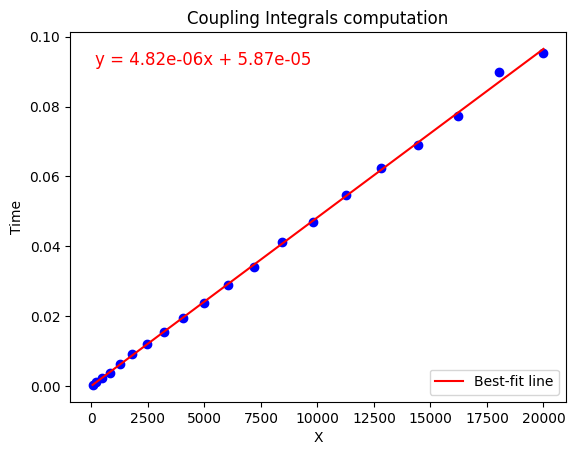

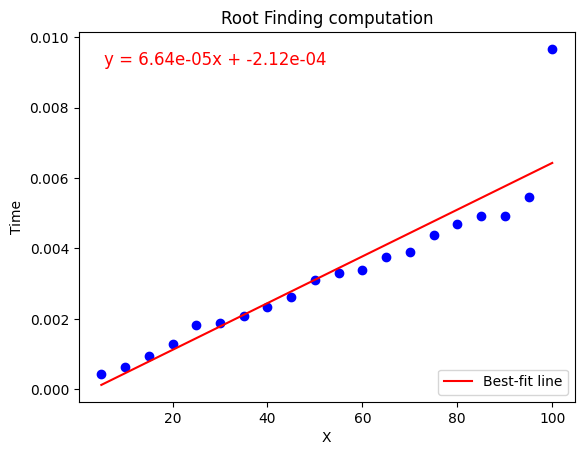

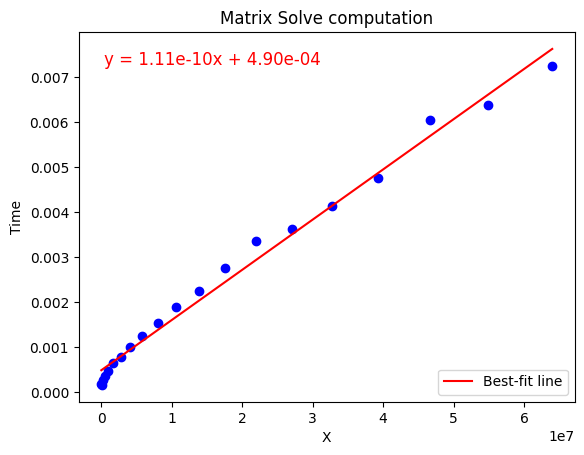

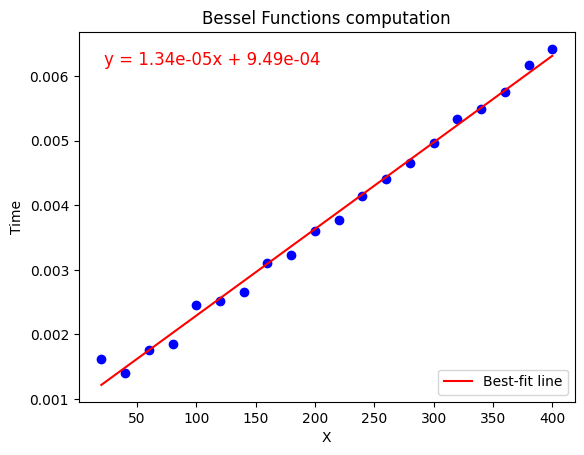

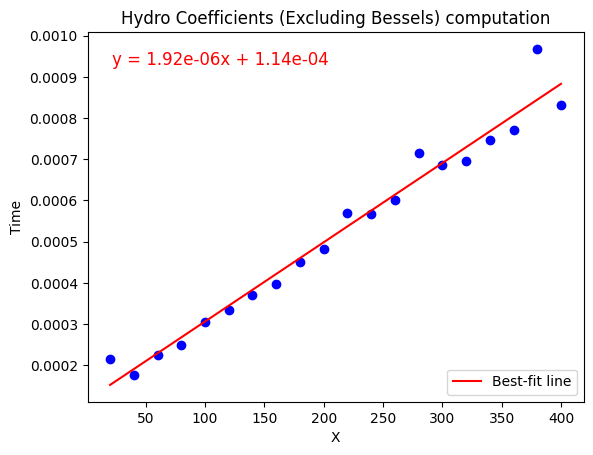

In [7]:
total_unknown_coeffs = lambda NMK: NMK[0] + 2 * sum(NMK[1:-1]) + NMK[-1]
coupling_dep = lambda NMK: sum([NMK[i] * NMK[i+1] for i in range(len(NMK)-1)])
time_dependencies = {"Coupling Integrals" : lambda NMK : coupling_dep(NMK),
                     "Root Finding" : lambda NMK : NMK[-1],
                     "Matrix Solve" : lambda NMK : (total_unknown_coeffs(NMK))**3,
                     "Bessel Functions" : lambda NMK : total_unknown_coeffs(NMK),
                     "Hydro Coefficients (Excluding Bessels)" : lambda NMK : total_unknown_coeffs(NMK)}

def plot_dependence(meem_data, key, xlab):
  xs = []
  ys = []
  NMKs = [[data["nmk"] for i in range(3)] for data in meem_data]
  for i in range(len(meem_data)):
    xs.append(time_dependencies[key](NMKs[i]))
    ys.append(meem_data[i][key])
  plt.scatter(xs, ys, color = "blue")
  coeffs = np.polyfit(xs, ys, deg=1)
  fit_fn = np.poly1d(coeffs)
  x_line = np.linspace(min(xs), max(xs), 100)
  slope, intercept = coeffs
  equation = f"y = {slope:.2e}x + {intercept:.2e}"
  plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
          fontsize=12, verticalalignment='top', color='red')
  plt.plot(x_line, fit_fn(x_line), color="red", label="Best-fit line")
  plt.xlabel(xlab)
  plt.ylabel("Time")
  plt.legend()
  plt.title(key + " computation")
  plt.show()
  return slope

tds_factors = {key : plot_dependence(meem_reorganized_data, key, "X") for key in named_meem_times}

In [12]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 10 # x and y label font size
leg_fs = lab_fs * 0.88 # legend font size
fig_h = 10 # figure height
fig_w = 4 # figure width

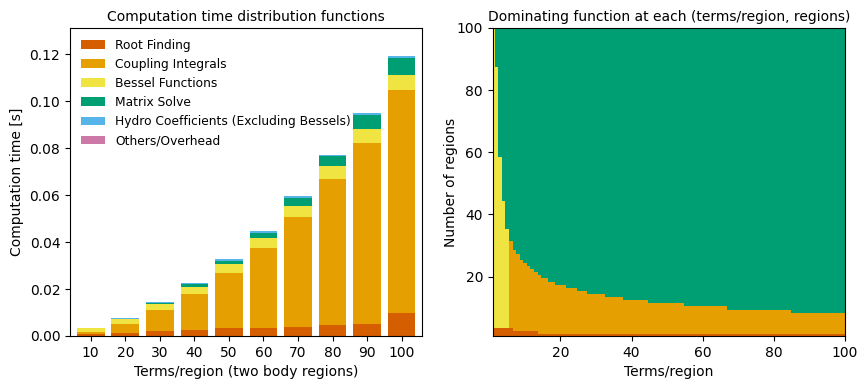

In [13]:
key_colors = {"Root Finding" : colors.red,
              "Coupling Integrals" : colors.orange,
              "Bessel Functions" : colors.yellow,
              "Matrix Solve" : colors.green,
              "Hydro Coefficients (Excluding Bessels)" : colors.skyblue,
              "Others/Overhead" : colors.purple}

def bar_chart(ax, meem_reorganized_data, key_colors):
  x = np.array([data["nmk"] for data in meem_reorganized_data])
  bottom = np.zeros(len(meem_reorganized_data))
  for k in key_colors.keys():
    heights = np.array([record.get(k, 0) for record in meem_reorganized_data])
    ax.bar(x, heights, bottom=bottom, width= 8, color=key_colors[k], label=k)
    bottom += heights

  ax.set_xticks(x)
  ax.set_xlabel("Terms/region (two body regions)", fontsize=lab_fs)
  ax.set_ylabel("Computation time [s]", fontsize=lab_fs)
  ax.legend(loc='upper left', fontsize=leg_fs, frameon=False)
  ax.set_ylim([0, max(bottom) * 1.1])
  ax.set_xlim([min(x) - 6, max(x) + 6])
  ax.set_title("Computation time distribution functions", fontsize=lab_fs, pad=5)

def times_contour(ax, key_colors, 
                  nmks, regions_lst,
                  time_dependencies, tds_factors):
  X, Y = np.meshgrid(nmks, regions_lst)
  keys = time_dependencies.keys()

  func_to_int = {key: i for i, key in enumerate(keys)}

  labels = np.zeros((len(regions_lst), len(nmks)), dtype = int)

  for j, regions in enumerate(regions_lst):
    for i, nmk in enumerate(nmks):
        NMK = [nmk for _ in range(regions)]
        results = {key : tds_factors[key] * time_dependencies[key](NMK) for key in keys}
        # get the function with the maximum (slowest) runtime
        slowest_func = max(results, key=results.get)
        labels[j, i] = func_to_int[slowest_func]

  colors_in_order = [key_colors[key] for key in keys]
  cmap = ListedColormap(colors_in_order)
  norm = BoundaryNorm(np.arange(-0.5, len(colors_in_order)+0.5), len(colors_in_order))
  extent = [nmks[0] - 0.5, nmks[-1] + 0.5,
            regions_lst[0] - 0.5, regions_lst[-1] + 0.5]

  im = ax.imshow(labels, cmap=cmap, norm=norm, origin="lower", extent=extent, interpolation="none", aspect="auto")

  ax.set_xlim([nmks[0], nmks[-1]])
  ax.set_ylim([regions_lst[0], regions_lst[-1]])
  ax.set_xlabel("Terms/region", fontsize=lab_fs)
  ax.set_ylabel("Number of regions", fontsize=lab_fs, labelpad=-1)
  ax.set_title("Dominating function at each (terms/region, regions)", fontsize=lab_fs, pad=5)

fig, ax = plt.subplots(1, 2, figsize=(fig_h, fig_w))
reduced_meem_data = [meem_reorganized_data[i] for i in range(len(meem_reorganized_data)) if i%2 == 1]
bar_chart(ax[0], reduced_meem_data, key_colors)
times_contour(ax[1], key_colors, list(range(1, 101)), list(range(1, 101)), time_dependencies, tds_factors)

full_path = figs_path_prefix + "/MEEM-Comp-Distribution.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')